In [6]:
from game import controlled_run

In [7]:
import numpy as np
from game import DO_NOTHING
from game import JUMP

import matplotlib.pyplot as plt

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from game import controlled_run

import random
import pandas as pd
from collections import deque


In [8]:
class Wrapper(object):
    def __init__(self,dqn_solver,games=20):
        self.dqn_solver = dqn_solver
        self.scores = []
        self.rewards = []
        self.epoch = 0
        self.games=games
        self.energy = 0
        self.energies = []
        controlled_run(self,0)
        
    def control(self,values):
        dqn_solver = self.dqn_solver
        if(values['closest_enemy'] != -1):
            state = [[values['closest_enemy']/1000,self.energy]]
            action = dqn_solver.act(state)
            if(action ==1):
                if(self.energy > 0): 
                    self.energies.append(self.energy)
                    self.energy = self.energy - 1

                else:
                    action = 0
                    self.energies.append(self.energy)
                
            else:
                self.energies.append(self.energy)
                self.energy = max(self.energy+1,3)


            print(action,state)

            self.action = action
            self.old_values= values
        else:
            action=0
            
        return action
    
    def reward(self,old_values,new_values,action,score,done=False):
        import Enemy
        if(old_values['closest_enemy'] != -1):
            if(len(self.energies) > 1):
                state = [[old_values['closest_enemy']/1000,self.energies[-2]]]
                next_state = [[new_values['closest_enemy']/1000,self.energies[-1]]]
            else:
                state = [[old_values['closest_enemy']/1000,self.energy]]
                next_state = [[new_values['closest_enemy']/1000,self.energy]]
            if(new_values['old_closest_enemy'] + 25 < 380 and new_values['old_closest_enemy'] + 25 != 24):
                print(new_values['old_closest_enemy'] + 25)
                reward = 1
                print("Rewarded for Jumping Over!")
            else:
                reward = 0#new_values['score_increased']
            if(done == True):
                reward = -1
                previous =  list(dqn_solver.memory[len(dqn_solver.memory)-1])
                previous[0] = previous[0]
                previous[1] = previous[1]
                previous[2] = reward
                previous[3] = next_state
                previous[4] = done
                previous = tuple(previous)
                dqn_solver.memory = dqn_solver.memory[0:(len(dqn_solver.memory)-1)]
                
                dqn_solver.memory.append(previous)

                # print(previous)

                print("Round: " + str(self.epoch) + " Score: " + str(score))
                # print(dqn_solver.memory[:-min(5,len(dqn_solver.memory))])

                dqn_solver.experience_replay()
            else:
                # print(state,action,reward,next_state,done)
                # print(dqn_solver.memory[:-5])
                dqn_solver.remember(state,action,reward,next_state,done)
                dqn_solver.experience_replay()
            self.rewards.append(reward)


    def get_scores(self):
        return self.scores
    
    def get_rewards(self):
        return self.rewards

    def setPlayer(self,player):
        self.player = player

    def setEnemy(self,enemy):
        self.enemy = enemy
    
    def setCurrentScore(self,score):
        self.currentScore = score

    def gameover(self,score,values):
        self.scores.append(score)
        pd.DataFrame(self.scores).to_csv("score.csv")

        print(self.epoch)
        self.epoch += 1
        if(self.epoch < self.games):
            self.energy = 0
            return controlled_run(self,self.epoch)

In [9]:
# Parameters
GAMMA = 0.5
ALPHA = 0.5
LR = 0.05
EPSILON = 0.99
EPS_DECAY = 0.95
class DQN:
    def __init__(self, observation_space, action_space):
        # Set parameters
        self.epsilon = EPSILON
        self.alpha = ALPHA
        self.gamma = GAMMA
        self.action_space = action_space
        self.observation_space = observation_space
        
        self.memory = []
        self.batch_size = 64

        # Neural Network MODEL
        '''
        self.model = Sequential()
        self.model.add(Dense(16, input_shape=(observation_space,), kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dense(32, kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dense(8, kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.2))
        self.model.add(Dropout(0.25))
        self.model.add(BatchNormalization())
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LR))
        '''

        # Run smaller network for speed
        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LR))
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            # print("RANDOM!")
            return random.randrange(self.action_space)
        print(state)
        q = self.model.predict(np.asarray(state))
        print("Measured: " + str(q[0]), state,np.argmax(q[0]))
        return np.argmax(q[0])

    def experience_replay(self):
        # print(self.memory,self.batch_size)
        import pandas as pd
    
        # organized_memory = pd.DataFrame([list(x) for x in self.memory])
        # organized_memory.columns = ['state','action','reward','next_state','done']
        # organized_memory['reward_abs'] = [abs(x) for x in organized_memory['reward']]
        # print(organized_memory['reward_abs'])
        # mem_sample=organized_memory.sample(n=min(len(self.memory),self.batch_size), weights='reward_abs').drop('rewards_abs',axis=1).values

       
        mem_sample = random.sample(self.memory, min(len(self.memory),self.batch_size))
        try:
            df_mem_sample = pd.DataFrame(mem_sample)
            df_mem_sample.columns = ['state','action','reward','next_state','done']

            df_mem_sample['reward_abs'] = df_mem_sample['reward'].apply(lambda x: 10*abs(x)+1 )
            df_mem_sample = df_mem_sample.sample(n=min(len(self.memory),self.batch_size), weights = 'reward_abs')
            mem_sample = df_mem_sample.drop('reward_abs',axis=1).values
            # print("MEM: ")
            # print(df_mem_sample)
           
        except Exception as e:
            print(e)
            pass

        start=True
        states=[]
        qs=[]
        for state, action, reward, next_state, done in mem_sample:

            # print(state, action, reward, next_state, done)
            update_value = reward
            # print(update_value)
            if not done:
                # print("Discounting")
                update_value = self.alpha * (reward + self.gamma * np.max(self.model.predict(next_state)[0]))

            q = self.model.predict(np.asarray(state))
            
            q[0][action] = update_value
            # print(state,type(state))
            # print(state,next_state,action,reward,q,done)
            states.append(state[0])
            qs.append([q[0][0],q[0][1]])
            # if start==True:
            #     states=np.array(state)
            #     qs=np.array(q)
            #     start=False
            # else:
            #     states = np.concatenate(states,np.array(state))
            #     qs=np.concatenate(qs,q)
        # print(qs)
        # print(np.asarray(states))
        self.model.fit(np.asarray(states), np.asarray(qs))
        self.epsilon *= EPS_DECAY
        print("Epsilon: " + str(self.epsilon))

        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

In [10]:
dqn_solver = DQN(2,2)
game = Wrapper(dqn_solver,30)

]]
2/2 [==============================] - 0s 3ms/step - loss: 0.0394
Epsilon: 1.7714355625039886e-06
[[0.574, 4]]
Measured: [-0.16874172 -0.24904373] [[0.574, 4]] 0
0 [[0.574, 4]]
2/2 [==============================] - 0s 2ms/step - loss: 0.0191
Epsilon: 1.682863784378789e-06
[[0.418, 5]]
Measured: [-0.13154356  0.04634759] [[0.418, 5]] 1
1 [[0.418, 5]]
Round: 21 Score: 3
2/2 [==============================] - 0s 4ms/step - loss: 0.0290
Epsilon: 1.5987205951598494e-06
21
[[1.0, 0]]
Measured: [-0.01024127 -0.04850861] [[1.0, 0]] 0
0 [[1.0, 0]]
2/2 [==============================] - 0s 3ms/step - loss: 0.0415
Epsilon: 1.5187845654018568e-06
[[0.979, 3]]
Measured: [ 0.03433244 -0.02584864] [[0.979, 3]] 0
0 [[0.979, 3]]
2/2 [==============================] - 0s 3ms/step - loss: 0.0302
Epsilon: 1.4428453371317638e-06
[[0.823, 4]]
Measured: [-0.06909542 -0.10164026] [[0.823, 4]] 0
0 [[0.823, 4]]
2/2 [==============================] - 0s 3ms/step - loss: 0.0370
Epsilon: 1.3707030702751756e-06

In [11]:
scores = game.get_scores()
sum(scores)/len(scores)

9.066666666666666

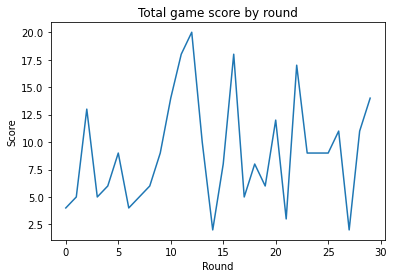

In [12]:
plt.plot(scores)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [13]:
scores_start = scores[:50]

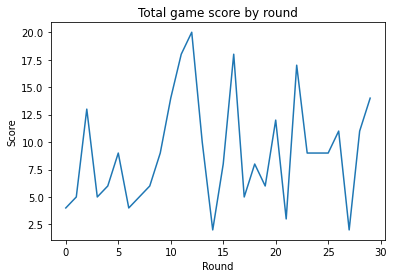

In [14]:
plt.plot(scores_start)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [15]:
rewards = np.array(game.get_rewards()).T

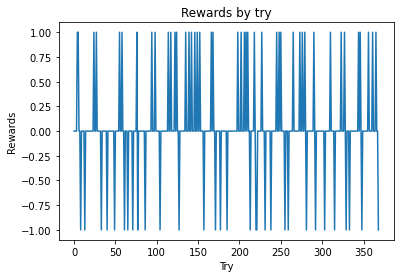

In [16]:
plt.plot(rewards)
plt.xlabel('Try')
plt.ylabel('Rewards')
plt.title('Rewards by try')
plt.show()